In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
class ImprovedCodeRedundancyDetector:
    def __init__(self, dataset_path=None, dataset=None):
        """
        Initialize the detector with either a dataset path or a pandas DataFrame

        Args:
            dataset_path: Path to JSON dataset file
            dataset: Pandas DataFrame with code1, code2, and label columns
        """
        if dataset_path:
            # Load dataset from file
            self.dataset = pd.read_json(dataset_path)
        elif dataset is not None:
            # Use provided dataset
            self.dataset = dataset
        else:
            raise ValueError("Either dataset_path or dataset must be provided")

        # Set model parameters
        self.embedding_dim = 100  # Increased from 50
        self.max_length = 150     # Increased from 100
        self.vocab_size = 10000   # Increased from 5000

        # Prepare data
        self.prepare_data()

    def prepare_data(self):
        """Prepare and preprocess the dataset for training"""
        # Extract features
        self.code1_samples = self.dataset['code1'].tolist()
        self.code2_samples = self.dataset['code2'].tolist()
        self.labels = self.dataset['label'].tolist()

        # Tokenization
        print("Tokenizing code1 samples...")
        self.code1_tokenizer = Tokenizer(num_words=self.vocab_size, oov_token="<OOV>")
        self.code1_tokenizer.fit_on_texts(self.code1_samples)
        code1_sequences = self.code1_tokenizer.texts_to_sequences(self.code1_samples)
        self.code1_padded = pad_sequences(code1_sequences, maxlen=self.max_length, padding='post', truncating='post')

        print("Tokenizing code2 samples...")
        self.code2_tokenizer = Tokenizer(num_words=self.vocab_size, oov_token="<OOV>")
        self.code2_tokenizer.fit_on_texts(self.code2_samples)
        code2_sequences = self.code2_tokenizer.texts_to_sequences(self.code2_samples)
        self.code2_padded = pad_sequences(code2_sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Split data
        print("Splitting data into training and test sets...")
        self.X1_train, self.X1_test, self.X2_train, self.X2_test, self.y_train, self.y_test = train_test_split(
            self.code1_padded,
            self.code2_padded,
            self.labels,
            test_size=0.2,
            random_state=42,
            stratify=self.labels  # Ensure balanced split
        )
        self.y_train = np.array(self.y_train)
        self.y_test = np.array(self.y_test)

        print(f"Training set size: {len(self.y_train)}")
        print(f"Test set size: {len(self.y_test)}")

    def build_model(self, model_type="bidirectional_lstm"):
        """
        Build the neural network model

        Args:
            model_type: Type of model architecture to use
                        Options: "lstm", "bidirectional_lstm", "gru", "transformer"
        """
        # Input layers for two code snippets
        input1 = tf.keras.layers.Input(shape=(self.max_length,))
        input2 = tf.keras.layers.Input(shape=(self.max_length,))

        # Embedding layer
        embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)

        # Embedded inputs
        embedded1 = embedding(input1)
        embedded2 = embedding(input2)

        # Choose model architecture
        if model_type == "lstm":
            # Basic LSTM architecture
            shared_lstm = tf.keras.layers.LSTM(128)
            lstm1 = shared_lstm(embedded1)
            lstm2 = shared_lstm(embedded2)

        elif model_type == "bidirectional_lstm":
            # Bidirectional LSTM architecture
            shared_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
            lstm1 = shared_lstm(embedded1)
            lstm2 = shared_lstm(embedded2)

        elif model_type == "gru":
            # GRU architecture
            shared_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))
            gru1 = shared_gru(embedded1)
            gru2 = shared_gru(embedded2)

            # Add attention mechanism
            attention = tf.keras.layers.Attention()
            attn1 = tf.keras.layers.GlobalAveragePooling1D()(gru1)
            attn2 = tf.keras.layers.GlobalAveragePooling1D()(gru2)

            lstm1 = attn1
            lstm2 = attn2

        elif model_type == "transformer":
            # Transformer architecture with positional encoding
            pos_encoding = self.positional_encoding(self.max_length, self.embedding_dim)

            # Add positional encoding to embeddings
            embedded1 = embedded1 + pos_encoding
            embedded2 = embedded2 + pos_encoding

            # Transformer encoder layer
            transformer_layer = tf.keras.layers.Transformer(
                num_heads=8,
                intermediate_dim=128,
                dropout=0.1
            )

            # Process each input separately
            trans1 = transformer_layer(embedded1, embedded1)
            trans2 = transformer_layer(embedded2, embedded2)

            # Global pooling to get fixed-length representation
            lstm1 = tf.keras.layers.GlobalAveragePooling1D()(trans1)
            lstm2 = tf.keras.layers.GlobalAveragePooling1D()(trans2)

        else:
            raise ValueError(f"Unknown model type: {model_type}")

        # Difference and product features
        # diff = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([lstm1, lstm2])
        # prod = tf.keras.layers.Lambda(lambda x: x[0] * x[1])([lstm1, lstm2])
        def abs_diff(tensors):
            x, y = tensors
            return tf.abs(x - y)

        def mul_prod(tensors):
            x, y = tensors
            return x * y

        diff = tf.keras.layers.Lambda(abs_diff)([lstm1, lstm2])
        prod = tf.keras.layers.Lambda(mul_prod)([lstm1, lstm2])


        # Merge layers - concatenate all features
        merged = tf.keras.layers.Concatenate()([lstm1, lstm2, diff, prod])

        # Dense layers with batch normalization
        dense1 = tf.keras.layers.Dense(256, activation='relu')(merged)
        bn1 = tf.keras.layers.BatchNormalization()(dense1)
        dropout1 = tf.keras.layers.Dropout(0.5)(bn1)

        dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
        bn2 = tf.keras.layers.BatchNormalization()(dense2)
        dropout2 = tf.keras.layers.Dropout(0.3)(bn2)

        # Output layer
        output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout2)

        # Create model
        self.model = tf.keras.Model(inputs=[input1, input2], outputs=output)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        # Print model summary
        self.model.summary()

        return self.model

    def positional_encoding(self, position, d_model):
        """
        Create positional encoding for transformer model
        """
        def get_angles(pos, i, d_model):
            angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
            return pos * angle_rates

        angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def train_model(self, epochs=20, batch_size=64, save_path="best_model.keras"):
        """
        Train the model with early stopping

        Args:
            epochs: Maximum number of epochs to train
            batch_size: Batch size for training
            save_path: Path to save the best model
        """
        # Set up callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        model_checkpoint = ModelCheckpoint(
            save_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )

        # Train the model
        history = self.model.fit(
            [self.X1_train, self.X2_train],
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )

        return history

    def evaluate_model(self):
        """Evaluate the model and display metrics"""
        # Get model predictions
        y_pred_prob = self.model.predict([self.X1_test, self.X2_test])
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Redundant', 'Redundant'])
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_pred_prob)
        plt.figure(figsize=(8, 6))
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        plt.title("Precision-Recall Curve")
        plt.tight_layout()
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_prob)
        auc_score = roc_auc_score(self.y_test, y_pred_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Distribution of redundancy scores
        plt.figure(figsize=(10, 6))
        sns.histplot(y_pred_prob[self.y_test == 1], color="blue", kde=True, label="Redundant")
        sns.histplot(y_pred_prob[self.y_test == 0], color="red", kde=True, label="Non-Redundant")
        plt.title("Distribution of Redundancy Scores")
        plt.xlabel("Redundancy Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

        return {
            'accuracy': np.mean(y_pred == self.y_test),
            'auc': auc_score,
            'confusion_matrix': cm
        }

    def predict_redundancy(self, code1, code2):
        """
        Predict if two code snippets are redundant

        Args:
            code1: First code snippet
            code2: Second code snippet

        Returns:
            prediction: Redundancy score between 0 and 1
        """
        # Preprocess input
        code1_seq = self.code1_tokenizer.texts_to_sequences([code1])
        code2_seq = self.code2_tokenizer.texts_to_sequences([code2])

        code1_padded = pad_sequences(code1_seq, maxlen=self.max_length, padding='post', truncating='post')
        code2_padded = pad_sequences(code2_seq, maxlen=self.max_length, padding='post', truncating='post')

        # Predict
        prediction = self.model.predict([code1_padded, code2_padded])
        return prediction[0][0]

    def save_model(self, model_path, tokenizer_path):
        """
        Save the model and tokenizers

        Args:
            model_path: Path to save the model
            tokenizer_path: Path to save the tokenizers
        """
        # Save model
        self.model.save(model_path)

        # Save tokenizers
        tokenizer_data = {
            'code1_tokenizer': self.code1_tokenizer.to_json(),
            'code2_tokenizer': self.code2_tokenizer.to_json()
        }

        with open(tokenizer_path, 'w') as f:
            json.dump(tokenizer_data, f)

    def load_model(self, model_path, tokenizer_path):
        """
        Load a saved model and tokenizers

        Args:
            model_path: Path to the saved model
            tokenizer_path: Path to the saved tokenizers
        """
        # Load model
        self.model = tf.keras.models.load_model(model_path)

        # Load tokenizers
        with open(tokenizer_path, 'r') as f:
            tokenizer_data = json.load(f)

        self.code1_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_data['code1_tokenizer'])
        self.code2_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_data['code2_tokenizer'])

In [9]:
def main():
    # Load the dataset
    dataset_path = "/content/Code_Similarity_Dataset.json"

    # Initialize the detector
    detector = ImprovedCodeRedundancyDetector(dataset_path=dataset_path)

    # Build the model (you can choose from "lstm", "bidirectional_lstm", "gru", or "transformer")
    detector.build_model(model_type="bidirectional_lstm")

    # Train the model
    history = detector.train_model(epochs=20, batch_size=64, save_path="best_code_redundancy_model.keras")

    # Evaluate the model
    metrics = detector.evaluate_model()
    print(f"Model evaluation metrics: {metrics}")

    # Save the model and tokenizers
    detector.save_model("code_redundancy_model.keras", "code_redundancy_tokenizers.json")

    # Example usage - detect redundancy in new code pairs
    code1 = """
    int yinshu(int be, int by) {
        int i, sum = 0;
        for (i = by; i * i <= be; i++) {
            if (be % i == 0) {
                sum += 1 + yinshu(be / i, i);
            }
        }
        return sum;
    }
    """

    code2 = """
    int countFactors(int number, int start) {
        int count = 0;
        for (int i = start; i * i <= number; i++) {
            if (number % i == 0) {
                count += 1 + countFactors(number / i, i);
            }
        }
        return count;
    }
    """

    redundancy_score = detector.predict_redundancy(code1, code2)
    print(f"Redundancy Score: {redundancy_score:.4f}")
    print(f"The code is {'redundant' if redundancy_score > 0.5 else 'not redundant'}.")

Tokenizing code1 samples...
Tokenizing code2 samples...
Splitting data into training and test sets...
Training set size: 40000
Test set size: 10000


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 150, 100)  │  1,000,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    234,496 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ bidirectional[0]… │
│                     │                   │            │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[1]… │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    262,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,531,457 (5.84 MB)

 Trainable params: 1,530,689 (5.84 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6610 - auc: 0.7190 - loss: 0.6567 - precision: 0.6478 - recall: 0.6891
Epoch 1: val_loss improved from inf to 0.44539, saving model to best_code_redundancy_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.6611 - auc: 0.7192 - loss: 0.6565 - precision: 0.6479 - recall: 0.6893 - val_accuracy: 0.7887 - val_auc: 0.8891 - val_loss: 0.4454 - val_precision: 0.8329 - val_recall: 0.7236
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8222 - auc: 0.8947 - loss: 0.4022 - precision: 0.7943 - recall: 0.8701
Epoch 2: val_loss improved from 0.44539 to 0.39578, saving model to best_code_redundancy_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.8222 - auc: 0.8947 - loss: 0.4021 - precision: 0.7943 - recall: 0.8701 - val_accuracy: 0.8216 - val_auc: 0.9091 - val_loss: 0.3958 - val_precision: 0.8401 - val_recall: 0.7955
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8

<Figure size 800x600 with 0 Axes>

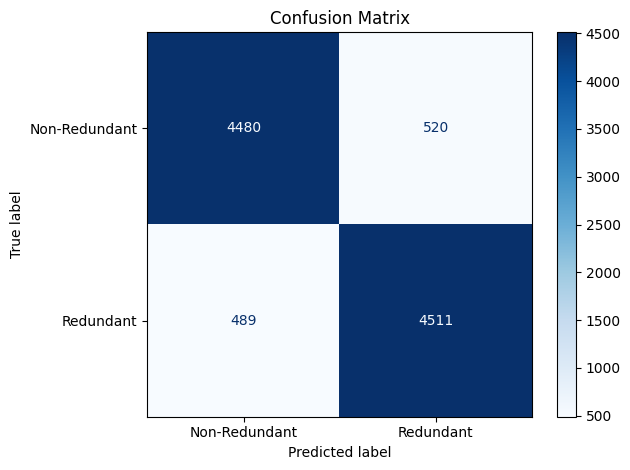

<Figure size 800x600 with 0 Axes>

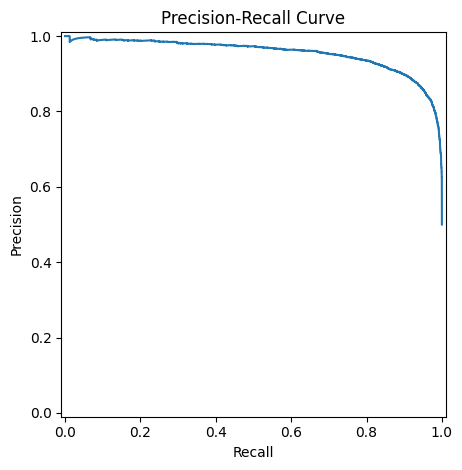

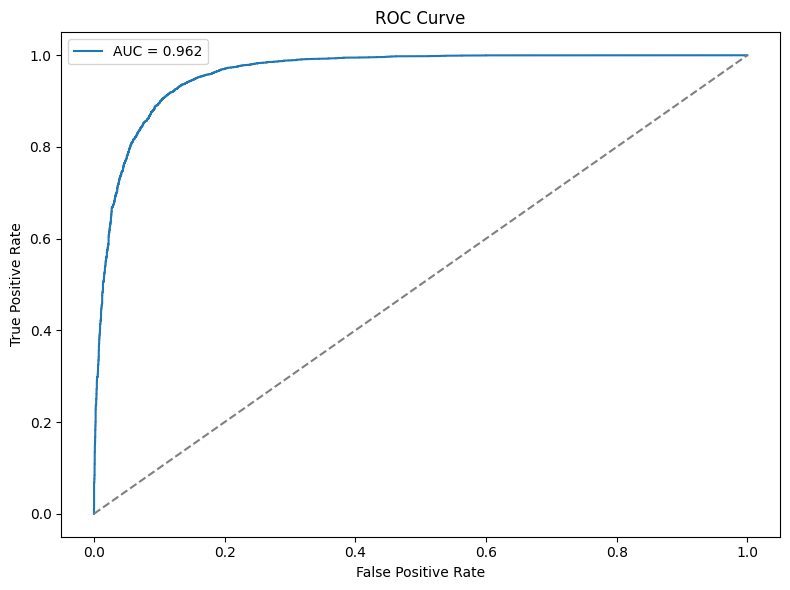

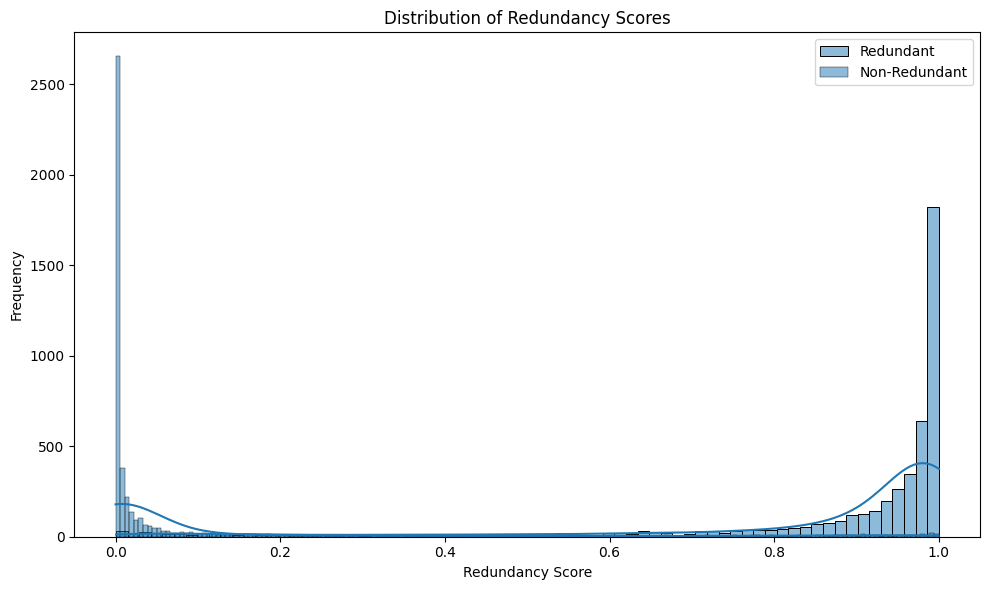

Model evaluation metrics: {'accuracy': np.float64(0.5), 'auc': np.float64(0.9620104799999999), 'confusion_matrix': array([[4480,  520],
       [ 489, 4511]])}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Redundancy Score: 0.9984
The code is redundant.


In [10]:
if __name__ == "__main__":
    main()